# Inpainting

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets
import matplotlib.pyplot as plt
import random
import cv2 as cv
import torch.optim as optim
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity
from torchmetrics.image.psnr import PeakSignalNoiseRatio
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure
import wandb

In [2]:
device = torch.device("cuda")

## Data

In [3]:
def cut_out_region(image: np.ndarray, region_size = 32) -> np.ndarray:
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    region_position_x = random.randint(32, image.shape[1] - region_size - 32)
    region_position_y = random.randint(32, image.shape[0] - region_size - 32)
    mask[
        region_position_y : region_position_y + region_size,
        region_position_x : region_position_x + region_size,
    ] = 1
    return (
        image[region_position_y : region_position_y + region_size,
        region_position_x : region_position_x + region_size],
        mask,
    )

In [4]:
class DIV2InpaintingKDataset(Dataset):
    def __init__(self, data, normalize_transform=None, region_size=32):
        self.data = data
        self.normalize_transform = normalize_transform
        self.region_size = region_size

    def __getitem__(self, idx):
        image = self.data[idx]
        if self.normalize_transform:
            image = self.normalize_transform(image[0])
        cutout, mask = cut_out_region(image.permute(1, 2, 0).numpy(), self.region_size)

        return image, torch.tensor(cutout).permute([2, 0, 1]), torch.tensor(cv.bitwise_and(image.permute(1, 2, 0).numpy(), image.permute(1, 2, 0).numpy(), mask=(1 - mask.astype(np.uint8)) * 255)).permute([2, 0, 1]), mask

    def __len__(self):
        return len(self.data)

In [5]:
IMAGE_WIDTH = 256
IMAGE_HIGHT = 256

SQUARE_SIZE = 32
DATASET_PATH = "/media/mikic202/Nowy/Random/DIV2_dataset/archive/DIV2K_train_HR"
VALIDATION_DATASET_PATH = "/media/mikic202/Nowy/Random/DIV2_dataset/archive/DIV2K_valid_HR"

mean = 0.5
std = 0.5
dataset = datasets.ImageFolder(root=DATASET_PATH)
validation_dataset = datasets.ImageFolder(root=VALIDATION_DATASET_PATH)

normalize_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((IMAGE_HIGHT, IMAGE_WIDTH)),
        # transforms.Normalize(mean=mean, std=std),
    ]
)

image_dataset = DIV2InpaintingKDataset(dataset, normalize_transform=normalize_transform, region_size=SQUARE_SIZE)
validation_dataset = DIV2InpaintingKDataset(validation_dataset, normalize_transform=normalize_transform, region_size=SQUARE_SIZE)

train_dataloader = DataLoader(image_dataset, batch_size=16, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=4, shuffle=True)

## Model

In [7]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.relu = nn.LeakyReLU(0.15)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return x


class SmallUNet(nn.Module):
    def __init__(self, input_channels=3, output_channels=3, base_ch=32):
        super().__init__()
        self.enc1 = ConvBlock(input_channels, base_ch)
        self.enc2 = ConvBlock(base_ch, base_ch*4)
        self.enc3 = ConvBlock(base_ch*4, base_ch*4)
        self.enc4 = ConvBlock(base_ch*4, base_ch*8)

        self.pool = nn.MaxPool2d(2)


        self.bottleneck1 = ConvBlock(base_ch*16, base_ch*16)
        self.bottleneck2 = ConvBlock(base_ch*8, base_ch*8)


        self.up4 = nn.ConvTranspose2d(base_ch*16, base_ch*8, kernel_size=2, stride=2)
        self.dec4 = ConvBlock(base_ch*8 + base_ch*8, base_ch*8)   # concat channels

        self.up3 = nn.ConvTranspose2d(base_ch*8, base_ch*4, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec3 = ConvBlock(base_ch*4 + base_ch*4, base_ch*4)   # concat channels

        self.up2 = nn.ConvTranspose2d(base_ch*4, base_ch*4, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec2 = ConvBlock(base_ch*4 + base_ch*4, base_ch*4)   # concat channels

        self.up1 = nn.ConvTranspose2d(base_ch*4, base_ch, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec1 = ConvBlock(base_ch + base_ch , base_ch)        # concat channels


        self.out_conv = nn.Conv2d(base_ch, output_channels, kernel_size=1)
        self.activation = nn.Sigmoid()
        # self.activation2 = nn.Sigmoid()

        # self.dec0 = ConvBlock(2*output_channels, output_channels)

    def bottleneck(self, x):
        x = self.bottleneck2(x)
        fft_out = torch.fft.rfft2(x, norm="ortho")
        freq_processed = self.bottleneck1(torch.cat([fft_out.real, fft_out.imag], dim=1))

        c = freq_processed.shape[1] // 2
        freq_real = freq_processed[:, :c]
        freq_imag = freq_processed[:, c:]

        fft_processed = torch.complex(freq_real, freq_imag)
        return torch.cat([torch.fft.irfft2(fft_processed, s=x.shape[-2:], norm="ortho"), x], dim=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.up4(b)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        out = self.out_conv(d1)

        # d0 = torch.nn.functional.interpolate(
        #     out, size=x.shape[2:], mode='bilinear', align_corners=False
        # )
        # out = self.activation2(out)
        # d0 = torch.cat([out, x], dim=1)
        # d0 = self.dec0(d0)
        d0 = self.activation(out)
        return d0

## Training

In [ ]:
model = SmallUNet(base_ch=40).to(device)

In [11]:
model = torch.jit.load("models/really_good_122_only_square_is_blurred_little_upgrade_to_107_sometimes_wierd_color_23.10.2025.pt").to(device)

In [ ]:
def hole_reconstruction_loss(original, reconstructed, mask, ssim = None):
    hole = mask.bool().unsqueeze(1)
    hole = hole.expand_as(reconstructed)
    if ssim is not None:
        mask_exp = mask.unsqueeze(1).float().to(reconstructed.device)
        return F.l1_loss(reconstructed[hole], original[hole]) + 1 - ssim(reconstructed * mask_exp, original * mask_exp)
    return F.l1_loss(reconstructed[hole], original[hole])

In [ ]:
LEARNING_RATE = 0.0002

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.82)
sism_criterion = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
criterion = nn.L1Loss()

In [ ]:
NUMBER_OF_EPOCHS = 10


run = wandb.init(
    project="SIGK-project-1",
    config={
        "learning_rate": LEARNING_RATE,
        "epochs": NUMBER_OF_EPOCHS,
        "loss": "L1 + SSIM",
        "base_ch": 40,
        "model": "SmallUNet with FFT for 3x3",
        "base": 122
    },
)


model.train()
for epoch in range(NUMBER_OF_EPOCHS):

    print(f"Started Epoch {epoch+1}/{NUMBER_OF_EPOCHS}")

    accumulated_loss = 0.0
    mask_loss = 0.0
    accumulatesd_ssim = 0.0
    accumulated_hole_loss = 0.0
    accumulated_criterion_loss = 0.0
    accumulated_color_losss = 0.0
    for original_images, _, altered_images, mask in train_dataloader:
        original_images = original_images.to(device)
        altered_images = altered_images.to(device)

        reconstructed_images = model(altered_images)
        reconstructed_images = torch.nn.functional.interpolate(
            reconstructed_images, size=original_images.shape[2:], mode='bilinear', align_corners=False
        )

        color_loss = torch.mean(torch.abs(reconstructed_images.mean(dim=[2,3]) - original_images.mean(dim=[2,3])))
        criterion_loss = criterion(reconstructed_images, original_images)
        holl_loss = hole_reconstruction_loss(original_images, reconstructed_images, mask, sism_criterion)
        ssim_value = sism_criterion(reconstructed_images, original_images)
        loss = criterion_loss + 2 * holl_loss + 0.8 * (1 - ssim_value)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        accumulated_loss += loss.item()
        accumulated_hole_loss += holl_loss.item()
        accumulatesd_ssim += ssim_value.item()
        accumulated_criterion_loss += criterion_loss.item()
        accumulated_color_losss += color_loss.item()

    avg_loss = accumulated_loss / len(train_dataloader)
    run.log({"loss": avg_loss,
             "hole_loss": accumulated_hole_loss / len(train_dataloader),
             "ssim": accumulatesd_ssim / len(train_dataloader),
             "criterion_loss": accumulated_criterion_loss / len(train_dataloader),
             "color_loss": accumulated_color_losss / len(train_dataloader)
            })
    print(f"Loss: {avg_loss:.6f}")
    if epoch % 10 == 0:
        scheduler.step()
run.finish()

In [ ]:
model_scripted = torch.jit.script(model.cpu())
model_scripted.save(
    "models/really_good_122_for_3x3___24.10.2025.pt"
)

## Evaluation

In [14]:
def get_image_scores(original_image: np.ndarray, altered_image: np.ndarray):
  original_image = torch.from_numpy(original_image).permute(2, 0, 1).unsqueeze(0).float() / 255.0
  altered_image = torch.from_numpy(altered_image).permute(2, 0, 1).unsqueeze(0).float() / 255.0
  return {
      "LPIPS" : LearnedPerceptualImagePatchSimilarity(net_type='squeeze')(original_image, altered_image),
      "PSNR" : PeakSignalNoiseRatio(1.0)(original_image, altered_image),
      "SSIM": StructuralSimilarityIndexMeasure()(original_image, altered_image)
  }

def measure_dataset_difference(original_images: list[np.ndarray], altered_images: list[np.ndarray]):
  results = pd.DataFrame([get_image_scores(og, alt) for og, alt in zip(original_images, altered_images)]).astype(float)
  return results.mean()

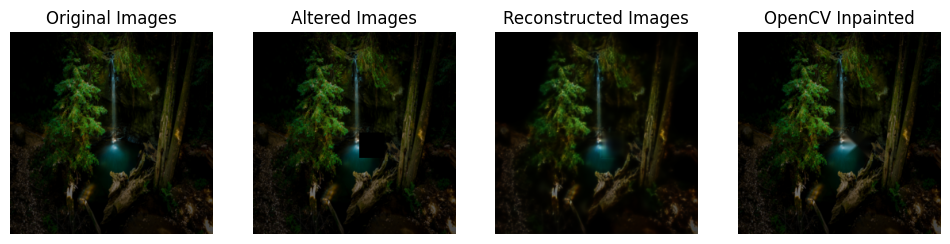

Altered vs Reconstructed: {'LPIPS': tensor(0.0030), 'PSNR': tensor(41.8895), 'SSIM': tensor(0.9929)}
Altered vs OpenCV Inpainted: {'LPIPS': tensor(0.0044), 'PSNR': tensor(35.6870), 'SSIM': tensor(0.9832)}


In [15]:
examples, square, altered_examples, mask = next(iter(validation_dataloader))
altered_examples = altered_examples.to(device)
model.eval()
with torch.no_grad():
    reconstructed_images = model(altered_examples)
examples = examples.cpu().numpy()
altered_examples = altered_examples.cpu().numpy()
reconstructed_examples = reconstructed_images.cpu().numpy()
plt.figure(figsize=(12, 6))
plt.subplot(1, 4, 1)
plt.title("Original Images")
plt.imshow(examples[0].transpose(1, 2, 0)
)
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("Altered Images")
plt.imshow(altered_examples[0].transpose(1, 2, 0))
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title("Reconstructed Images")
plt.imshow(reconstructed_examples[0].transpose(1, 2, 0))
plt.axis('off')

img_np = examples[0].transpose(1, 2, 0)
if img_np.max() <= 1.0:
    img_np = (img_np * 255).astype(np.uint8)
else:
    img_np = img_np.astype(np.uint8)

mask_np = mask.cpu().numpy()[0]
mask_np = (mask_np) * 255
mask_np = mask_np.astype(np.uint8)

img_bgr = cv.cvtColor(img_np, cv.COLOR_RGB2BGR)

dst = cv.inpaint(img_bgr, mask_np, 3, cv.INPAINT_TELEA)

dst_rgb = cv.cvtColor(dst, cv.COLOR_BGR2RGB)

plt.subplot(1, 4, 4)
plt.title("OpenCV Inpainted")
plt.imshow(dst_rgb)
plt.axis('off')
plt.show()



only_square_replacement = altered_examples[0].copy() + reconstructed_examples[0].copy() * mask.numpy()[0][np.newaxis, :, :]

print("Altered vs Reconstructed:", get_image_scores(examples[0].transpose(1, 2, 0) * 255, only_square_replacement.transpose(1, 2, 0) * 255))
print("Altered vs OpenCV Inpainted:", get_image_scores(examples[0].transpose(1, 2, 0) * 255, dst_rgb))

In [9]:
def get_inpaintings_for_dataset_with_cnn(dataset, hole_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if hole_size == 32:
        model = torch.jit.load("models/really_good_122_only_square_is_blurred_little_upgrade_to_107_sometimes_wierd_color_23.10.2025.pt").to(device)
    elif hole_size == 3:
        model = torch.jit.load("models/really_good_122_for_3x3_24.10.2025.pt").to(device)
    else:
        raise NotImplementedError("Only hole sizes of 3 and 32 are supported.")
    test_dataloader = DataLoader(dataset, batch_size=16, shuffle=False)
    original_images = []
    altered_images = []
    reconstructed_images = []
    only_square_replacements = []
    model.eval()

    with torch.no_grad():
        for original_image, _, altered_image, mask in test_dataloader:
            original_images.extend(original_image.numpy().transpose(0, 2, 3, 1) * 255)
            altered_images.append(altered_image.numpy().transpose(0, 2, 3, 1) * 255)
            altered_image = altered_image.to(device)
            reconstructed_image = model(altered_image)
            reconstructed_image = torch.nn.functional.interpolate(
                reconstructed_image, size=original_image.shape[2:], mode='bilinear', align_corners=False
            )
            reconstructed_images.append(reconstructed_image.cpu().numpy().transpose(0, 2, 3, 1) * 255)
            only_square_replacements.extend([(altered_image.cpu().numpy()[i] + reconstructed_image.cpu().numpy()[i] * mask.numpy()[i][np.newaxis, :, :]).transpose(1, 2, 0) * 255 for i in range(reconstructed_image.shape[0])])

    return original_images, altered_images, reconstructed_images, only_square_replacements

In [10]:
def get_inpaintings_for_dataset_with_opencv(dataset):
    original_images = []
    altered_images = []
    inpainted_images = []
    for original_image, _, altered_image, mask in dataset:
        original_images.append(original_image.numpy().transpose(1, 2, 0) * 255)
        altered_images.append(altered_image.numpy().transpose(1, 2, 0) * 255)
        img_np = original_image.numpy().transpose(1, 2, 0)
        if img_np.max() <= 1.0:
            img_np = (img_np * 255).astype(np.uint8)
        else:
            img_np = img_np.astype(np.uint8)

        mask_np = (mask) * 255
        mask_np = mask_np.astype(np.uint8)

        img_bgr = cv.cvtColor(img_np, cv.COLOR_RGB2BGR)

        dst = cv.inpaint(img_bgr, mask_np, 3, cv.INPAINT_TELEA)

        dst_rgb = cv.cvtColor(dst, cv.COLOR_BGR2RGB)
        inpainted_images.append(dst_rgb)
    return original_images, altered_images, inpainted_images, inpainted_images

In [11]:
def measure_inpainting_model_performance(dataset: Dataset, inpainting_method, wariations_per_image=1):
    original_images = []
    inpainted_images = []
    with torch.no_grad():
        for _ in range(wariations_per_image):
            original, _, _ ,inpainted =inpainting_method(dataset)
            original_images.extend(original)
            inpainted_images.extend(inpainted)
    return measure_dataset_difference(original_images, inpainted_images)

In [12]:
measure_inpainting_model_performance(validation_dataset, lambda dataset: get_inpaintings_for_dataset_with_cnn(dataset, 32), wariations_per_image=10)

LPIPS     0.009412
PSNR     36.256023
SSIM      0.990129
dtype: float64

In [15]:
measure_inpainting_model_performance(validation_dataset, get_inpaintings_for_dataset_with_opencv, wariations_per_image=10)

LPIPS     0.183136
PSNR     29.569249
SSIM      0.773369
dtype: float64